In [58]:
from __future__ import unicode_literals, print_function, division

import os
from io import open
import sys
import math
import random
import argparse
import operator
import pdb

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


from collections import defaultdict
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Kyle's attempt
import faker
from faker import Faker
import pandas as pd
import numpy as np
import re
from string import punctuation
import glob
import unicodedata
import string
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fake = Faker()

In [40]:
print(__name__)

__main__


In [59]:
# reading in some data to help with training
ccs= pd.read_csv('datasets/lookups/county_cc_c_number.csv')
cc= pd.read_csv('datasets/lookups/continent_code.csv')

In [60]:
#creating arrays to random select from
unique_ccodes=ccs['CC'].unique()
cont_names=cc['continent_name'].unique()
cont_codes=cc['continent_code'].unique()
cont_codes[1]='NA'

In [63]:
CHOICES = [
    'date_%Y-%m-%d', 
    'date_%Y_%m_%d',
    'date_%Y/%m/%d',
    'date_%Y.%m.%d',
    
    'date_%m-%d-%Y',
    'date_%m-%d-%y',
    
    'date_%m_%d_%Y',
    'date_%m_%d_%y',
    
    'date_%m/%d/%Y',
    'date_%m/%d/%y',
    
    'date_%m.%d.%Y',
    'date_%m.%d.%y',
    
    'date_%d-%m-%Y',
    'date_%d-%m-%y',
    
    'date_%d_%m_%Y',
    'date_%d_%m_%y',
    
    'date_%d/%m/%Y',
    'date_%d/%m/%y',
    
    'date_%d.%m.%Y',
    'date_%d.%m.%y',
    'date_%Y%m%d',
    'date_%Y%d',
    'date_%Y-%m',
    'date_%Y/%m',
    'date_%Y.%m',
    'date_long_dmdy',
    'date_long_mdy',
    'date_long_dmdyt',
    'date_long_mdyt_m',
    'date_long_dmonthY',
    'date_long_dmonthy',
    'iso8601',
    'month',
    'year',
    'zipcode',
    'geo',
    'city',
    'city_suffix',
    'country_name',
    'country_GID',
    'country_code',
    'percent',
    'phone_number',
    'first_name',
    'language_name',
    'prefix',
    'boolean',
    'boolean_letter',
    'pyfloat',
    'pystr',
    'ssn',
    'paragraph',
    'isbn',
    'email',
    'continent',
    'day_of_month',
    'day_of_week',
    'month_name',
    'date_%Y-%m-%d %H:%M:%S',
    'unix_time'
]
CONTINENTS=[
    'cont_code',
    'cont_name'
]
ISBN = [
    'isbn10',
    'isbn13'
]

SENTENCE_LEN = [
    1,
    2,
    3,
    4
]

CITY = [
        
        'city'
]

EMAIL =[
     'ascii_email',
    'company_email'
]


PERCENT =[
    10,
    100,
    1000
]
GEO = [
    'coordinate',
    'latitude',
    'longitude',
    'LatLong'
]
# DATELONG=['dmdy','mdy','dmdyt','mdyt_m']

# this class creates are randomized dataset and splits it into training ,validation and testing sets
class FakeData:
    def __init__(self , isbn = ISBN, continents=CONTINENTS, sentence_len = SENTENCE_LEN, email=EMAIL, choices = CHOICES, geo = GEO,  percent = PERCENT):
        self.fake = Faker()
        self.choices = choices
        self.continents = continents
        self.percent = percent
        self.geo = geo
        self.email = email
        self.sentence_len = sentence_len
        self.isbn = ISBN
        self.all_characters = string.ascii_letters + "1234567890 .,;'*!@#$%^&()_=-:+/`~|}{"
        self.n_characters = len(string.ascii_letters + "1234567890 .,;'*!@#$%^&()_=-:+/`~|}{")
        self.category_values={}
        self.all_categories=['city' ,'first_name',
                             'geo','percent' ,
                             'year', 'ssn', 
                             'language_name', 'country_name', 
                             'phone_number' ,'month', 
                             'zipcode', 'iso8601',
                             'paragraph', 'pyfloat',
                             'email', 'prefix' ,
                             'pystr', 'isbn', 
                             'boolean', 'country_code',
                             'country_GID' ,'continent',
                             'day_of_month', 'day_of_week',
                             'date_%Y-%m-%d', 'date_%Y_%m_%d',
                             'date_%Y/%m/%d', 'date_%Y.%m.%d',
                                
                             'date_%m-%d-%Y', 'date_%m-%d-%y',
                             'date_%m_%d_%Y','date_%m_%d_%y',

                             'date_%m/%d/%Y','date_%m/%d/%y',
                             'date_%m.%d.%Y', 'date_%m.%d.%y', 
                             'date_%d-%m-%Y','date_%d-%m-%y',
                             'date_%d_%m_%Y' , 'date_%d_%m_%y',
                             'date_%d/%m/%Y','date_%d/%m/%y',
                             'date_%d.%m.%Y','date_%d.%m.%y', 
                             'date_%Y%m%d','date_%Y%d',
                             'date_%Y-%m','date_%Y/%m',
                             'date_%Y.%m','date_long_dmdy', 
                             'date_long_mdy','date_long_dmdyt',
                             'date_long_mdyt_m','date_long_dmonthY' ,
                             'date_long_dmonthy','city_suffix',
                             'month_name', 'boolean_letter','date_%Y-%m-%d %H:%M:%S', 'unix_time']
        self.training_set_size = 250000
        self.dev_set_size = 15000
        self.test_set_size = 40000
        self.tag2id = defaultdict(int,
                        {'city': 0,
                         'first_name': 1,
                         'geo': 2,
                         'percent': 3,
                         'year': 4,
                         'ssn': 5,
                         'language_name': 6,
                         'country_name': 7,
                         'phone_number': 8,
                         'month': 9,
                         'zipcode': 10,
                         'iso8601': 11,
                         'paragraph': 12,
                         'pyfloat': 13,
                         'email': 14,
                         'prefix': 15,
                         'pystr': 16,
                         'isbn': 17,
                         'boolean': 18,
                         'country_code':19,
                         'country_GID':20,
                         'continent':21,
                         'date_%Y-%m-%d': 22,
                         'date_%Y_%m_%d': 23,
                         'date_%Y/%m/%d':24,
                         'date_%Y.%m.%d': 25,
                         'date_%m-%d-%Y': 26,
                         'date_%m-%d-%y': 27,
                         'date_%m_%d_%Y': 28,
                         'date_%m_%d_%y': 29,
                         'date_%m/%d/%Y': 30,
                         'date_%m/%d/%y': 31,
                         'date_%m.%d.%Y': 32,
                         'date_%m.%d.%y': 33,
                         'date_%d-%m-%Y': 34,
                         'date_%d-%m-%y': 35,
                         'date_%d_%m_%Y': 36 ,
                         'date_%d_%m_%y': 37,
                         'date_%d/%m/%Y': 38,
                         'date_%d/%m/%y': 39,
                         'date_%d.%m.%Y': 40,
                         'date_%d.%m.%y': 41, 
                         'date_%Y%m%d': 42,
                         'date_%Y%d': 43,
                         'date_%Y-%m':44,
                         'date_%Y/%m':45,
                         'date_%Y.%m': 46,
                         'day_of_month':47,
                         'day_of_week':48,
                         'date_long_dmdy':49,
                         'date_long_mdy': 50,
                         'date_long_dmdyt':51,
                         'date_long_mdyt_m':52,
                         'date_long_dmonthY':53,
                         'date_long_dmonthy':54,
                         'city_suffix':55,
                         'month_name':56,
                         'boolean_letter': 57,
                         'date_%Y-%m-%d %H:%M:%S': 58,
                         'unix_time': 59
                         })
        self.n_categories = len(self.tag2id)
        self.token_set={'a','b','c','d','e',
                        'f','g','h','i','j','k','l',
                        'm','n','o','p','q','r','s',
                        't','u','v','w','x','y','z',
                        'A','B','C','D','E','F','G',
                        'H','I','J','K','L','M','N',
                        'O','P','Q','R','S','T','U',
                        'V','W','X','Y','Z','1','2',
                        '3','4','5','6','7','8','9','0',
                        "'",',','.',';','*','!','@',
                        '#','$','%','^','&','(',')',
                        '_','=','-',':','+','/',"\\",
                        '`','~','|','}','{'}
        self.token2id = defaultdict(int,
            {'PAD': 0,
             'UNK': 1,
             'a':2,
             'b':3,
             'c': 4,
             'd': 5,
             'e': 6,
             'f': 7,
             'g':8,
             'h': 9,
             'i': 10,
             'j':11,
             'k':12,
             'l':13,
             'm':14,
             'n':15,
             'o':16,
             'p':17,
             'q':18,
             'r':19,
             's':20,
             't':21,
             'u':22,
             'v':23,
             'w':24,
             'x':25,
             'y':26,
             'z':27,
             'A':28,
             'B':29,
             'C':30,
             'D':31,
             'E':32,
             'F':33,
             'G':34,
             'H':35,
             'I':36,
             'J':37,
             'K':38,
             'L':39,
             'N':40,
             'O':41,
             'P':42,
             'Q':43,
             'R':44,
             'S':45,
             'T':46,
             'U':47,
             'V':48,
             'W':49,
             'X':50,
             'Y':51,
             'Z':52,
             '1':53,
             '2':54,
             '3':55,
             '4':56,
             '5':57,
             '6':58,
             '7':59,
             '8':60,
             '9':61,
             '0':62,
             "'":63,
             ',':64,
             '.':65,
             ';':66,
             '*':67,
             '!':68,
             '@':68,
             '#':70,
             '$':71,
             '%':72,
             '^':73,
             '&':74,
             '(':75,
             ')':76,
             '_':77,
             '=':78,
             '-':79,
             ':':80,
             '+':81,
             '/':82,
             '\\':83,
             '`':84,
             '~':85,
             '|':86,
             '}':87,
             '{':88
            })
                 
                                    
    def get_char_vocab(self):                    
            return self.token2id
    
    def get_tag2id(self):

        return self.tag2id

    def datapoint(self):
        lab = np.random.choice(self.choices)
        type_of_geo = np.random.choice(self.geo)
        email = np.random.choice(self.email)
        sentence_len = np.random.choice(self.sentence_len)
        isbn = np.random.choice(self.isbn)
        conts= np.random.choice(self.continents)
        
        def get_fake_date(lab):
                lab=lab[5:]
                return str(fake.date(pattern=lab))

#         val = self.fake

        if lab == 'geo':
            remove_or_add_digits= np.random.choice([15,15,15,15,6,7,-1])

            if type_of_geo == 'LatLong':
                val = str(getattr(self.fake, "latitude")())[:remove_or_add_digits] + ", " + str(getattr(self.fake, "longitude")())[:remove_or_add_digits]
            else:
                val = str(getattr(self.fake, type_of_geo)())[:remove_or_add_digits]
        elif lab == 'email':
            val = getattr(self.fake, email)()
        elif lab == 'paragraph':
            val = fake.paragraph(nb_sentences=sentence_len)

        elif lab == 'date_%Y-%m-%d':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y_%m_%d':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y/%m/%d':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y.%m.%d':
            val = get_fake_date(lab)
            
        elif lab =='date_%Y%m%d':
            val = get_fake_date(lab)

        elif lab == 'date_%Y%d':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y-%m':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y/%m':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y.%m':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m-%d-%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m-%d-%y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m_%d_%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m_%d_%y':
            val = get_fake_date(lab)
              
        elif lab == 'date_%m/%d/%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m/%d/%y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m.%d.%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m.%d.%y':
            val = get_fake_date(lab)
            
            
        elif lab == 'date_%d-%m-%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d-%m-%y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d_%m_%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d_%m_%y':
            val = get_fake_date(lab)
            
        
        elif lab == 'date_%d/%m/%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d/%m/%y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d.%m.%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d.%m.%y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y-%m-%d %H:%M:%S':
            val = get_fake_date(lab)
            print("val", val)
            
        elif lab == 'unix_time':
            val = str(fake.unix_time())
            print( 'unix_time', val)
            
        elif lab == 'date_long_dmdy':
#                 date_long_dmdy
                # Thursday, April 10, 2008
                dayExample = str(getattr(self.fake, "day_of_month")())
                dayExample_name = str(getattr(self.fake, "day_of_week")())
                monthExample = str(getattr(self.fake, "month_name")())
                yearExample = str(getattr(self.fake, "year")())
                val = dayExample_name + ', '+ monthExample + ' '+ dayExample + ', '+ yearExample 
        elif lab == 'date_long_mdy':
                #  April 10, 2008

                dayExample = str(getattr(self.fake, "day_of_month")())
                dayExample_name = str(getattr(self.fake, "day_of_week")())
                monthExample = str(getattr(self.fake, "month_name")())
                yearExample = str(getattr(self.fake, "year")())
                val =  monthExample + ' '+ dayExample + ', '+ yearExample 
        elif lab == 'date_long_dmdyt':
                #  Thursday, April 10, 2008 6:30:00 AM  
                dayExample = str(getattr(self.fake, "day_of_month")())
                dayExample_name = str(getattr(self.fake, "day_of_week")())
                monthExample = str(getattr(self.fake, "month_name")())
                yearExample = str(getattr(self.fake, "year")())
                timeDate = str(getattr(self.fake, "date_time_this_century")())
                time = timeDate.split(' ')[1]
                
                val = dayExample_name + ', '+ monthExample + ' '+ dayExample + ', '+ yearExample + ', '+ time
        elif lab == 'date_long_dmonthY':
                #  01 April 2008 
                dayExample = str(getattr(self.fake, "day_of_month")())
                
                monthExample = str(getattr(self.fake, "month_name")())
                yearExample = str(getattr(self.fake, "year")())
                
                
                val =  dayExample + ' '+ monthExample + ' ' +yearExample 
        elif lab == 'date_long_dmonthy':
                #  01 April 08 
                dayExample = str(getattr(self.fake, "day_of_month")())
                
                monthExample = str(getattr(self.fake, "month_name")())
                yearExample = str(getattr(self.fake, "year")())
                shortYear=yearExample[:2]
                
                val =  dayExample + ' '+ monthExample + ' ' +shortYear 
        elif lab == 'date_long_mdyt_m':
#         #                 03/23/21 01:55 PM
                dateExample = str(fake.date(pattern='%m/%d/%y'))
                
                timeDate = str(getattr(self.fake, "date_time_this_century")())
                
                time = timeDate.split(' ')[1]
                ampm = str(fake.am_pm())
                val = dateExample + ' '+ time + ' '+ ampm
        
        elif lab == 'country_name':
            val = getattr(self.fake, "country")()
        elif lab == 'country_GID':
            val = np.random.choice(unique_ccodes)
        elif lab == 'country_code':
             val = getattr(self.fake, "country_code")()
        elif lab == 'continent':
            
            if conts == 'cont_code':
                    val = np.random.choice(cont_codes)
            else: 
                    val = np.random.choice(cont_names)

        elif lab == 'isbn':
            val = getattr(self.fake, isbn)()
        elif lab == 'boolean_letter':
            letters=['t', 'f','T', 'F']
            val = np.random.choice(letters)
        elif lab == 'percent':

            scale = lambda x: x / np.random.choice(self.percent)

            val = str(np.random.choice(scale(np.array(list(range(0, 100))))))

        else:

            val = str(getattr(self.fake, lab)())
        return {"hash" : lab, "obj" : val}

    def dataframe(self, size ):
        self.df = pd.DataFrame([self.datapoint() for i in range(size)])
        self.get_category_values()
#         self.updateAllCharacters()
        return self.df

    def get_category_values(self):
        print('self.all_categories',self.all_categories)

        for category in self.all_categories:
            bool_array = self.df['hash']==category
            self.category_values[category]=self.df[bool_array]


    def unicodeToAscii(s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in all_characters
        )

    def randomChoice(self, values):
        return values[random.randint(0, len(values) - 1)]

    def getRandomSet(self):
        category = self.randomChoice(self.all_categories)
#         print(category)
        line = self.randomChoice(list(self.category_values[category]['obj']))
#         print('line', line)
        return (line, category)

    def updateAllCharacters(self):
        for x in (self.df['obj'].values):
            for y in list(str(x)):
                if y in self.all_characters:
                    pass
                else:
                    self.all_characters += y
                    self.n_characters = len(self.all_characters)

    def split_data(self):

#         """
#         Split data into train, dev, and test (currently use 80%/10%/10%)
#         It is more make sense to split based on category, but currently it hurts performance
#         """
        train_split = []
        dev_split = []
        test_split = []

        for _ in range(self.training_set_size):
            train_split.append(self.getRandomSet())

        for _ in range(self.dev_set_size):
            dev_split.append(self.getRandomSet())

        for _ in range(self.test_set_size):
            test_split.append(self.getRandomSet())


        return train_split, dev_split, test_split
    

    def set2id(self, item_set, pad=None, unk=None):
            item2id = defaultdict(int)
            if pad is not None:
                item2id[pad] = 0
            if unk is not None:
                item2id[unk] = 1

            for item in item_set:
                item2id[item] = len(item2id)

            return item2id


# This class pads our vectors to the correct length.   
class PaddedTensorDataset(Dataset):

    def __init__(self, data_tensor, target_tensor, length_tensor, raw_data):
        assert data_tensor.size(0) == target_tensor.size(0) == length_tensor.size(0)
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
        self.length_tensor = length_tensor
        self.raw_data = raw_data

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index], self.length_tensor[index], self.raw_data[index]

    def __len__(self):
        return self.data_tensor.size(0)

In [64]:
# This is the model
class LSTMClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(LSTMClassifier, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1)

        self.hidden2out = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        self.dropout_layer = nn.Dropout(p=0.2)


    def init_hidden(self, batch_size):
        return(autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)),
                    autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)))


    def forward(self, batch, lengths):

        self.hidden = self.init_hidden(batch.size(-1))

        embeds = self.embedding(batch)
        packed_input = pack_padded_sequence(embeds, lengths)
        outputs, (ht, ct) = self.lstm(packed_input, self.hidden)
        output = self.dropout_layer(ht[-1])
        output = self.hidden2out(output)
        output = self.softmax(output)

        return output

In [65]:
#  Helper functions
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence



def vectorized_data(data, item2id):
    return [[item2id[token] if token in item2id else item2id['UNK'] for token in str(seq)] for seq, _ in data]


def pad_sequences(vectorized_seqs, seq_lengths):
    # create a zero matrix
    seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()

    # fill the index
    for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    return seq_tensor


def create_dataset(data, input2id, target2id, batch_size=4):
    vectorized_seqs = vectorized_data(data, input2id)
    seq_lengths = torch.LongTensor([len(s) for s in vectorized_seqs])
    seq_tensor = pad_sequences(vectorized_seqs, seq_lengths)
    target_tensor = torch.LongTensor([target2id[y] for _, y in data])
    raw_data = [x for x, _ in data]

    return DataLoader(PaddedTensorDataset(seq_tensor, target_tensor, seq_lengths, raw_data), batch_size=batch_size)


def sort_batch(batch, targets, lengths):
    seq_lengths, perm_idx = lengths.sort(0, descending=True)
    seq_tensor = batch[perm_idx]
    target_tensor = targets[perm_idx]

    return seq_tensor.transpose(0, 1), target_tensor, seq_lengths


In [66]:
#train and evaluate model
def apply(model, criterion, batch, targets, lengths):
    pred = model(torch.autograd.Variable(batch), lengths.cpu().numpy())
#     print(pred,'pred')
    loss = criterion(pred, torch.autograd.Variable(targets))
    return pred, loss


def train_model(model, optimizer, train, dev, x_to_ix, y_to_ix, batch_size, max_epochs):
    criterion = nn.NLLLoss(size_average=False)
    for epoch in range(max_epochs):
        print('Epoch:', epoch)
        y_true = list()
        y_pred = list()
        total_loss = 0
        for batch, targets, lengths, raw_data in create_dataset(train, x_to_ix, y_to_ix, batch_size=32):
            batch, targets, lengths = sort_batch(batch, targets, lengths)
            model.zero_grad()
            pred, loss = apply(model, criterion, batch, targets, lengths)
            loss.backward()
            optimizer.step()
            
            pred_idx = torch.max(pred, 1)[1]
            y_true += list(targets.int())
            y_pred += list(pred_idx.data.int())
            total_loss += loss
        acc = accuracy_score(y_true, y_pred)
        val_loss, val_acc = evaluate_validation_set(model, dev, x_to_ix, y_to_ix, criterion)
        print("Train loss: {} - acc: {} \nValidation loss: {} - acc: {}".format(total_loss.data.float()/len(train), acc,
                                                                                val_loss, val_acc))
    return model


def evaluate_validation_set(model, devset, x_to_ix, y_to_ix, criterion):
    y_true = list()
    y_pred = list()
    total_loss = 0
    for batch, targets, lengths, raw_data in create_dataset(devset, x_to_ix, y_to_ix, batch_size=1):
        batch, targets, lengths = sort_batch(batch, targets, lengths)
        pred, loss = apply(model, criterion, batch, targets, lengths)
        pred_idx = torch.max(pred, 1)[1]
        y_true += list(targets.int())
        y_pred += list(pred_idx.data.int())
        total_loss += loss
    acc = accuracy_score(y_true, y_pred)
    return total_loss.data.float()/len(devset), acc


def evaluate_test_set(model, test, x_to_ix, y_to_ix):
    y_true = list()
    y_pred = list()

    for batch, targets, lengths, raw_data in create_dataset(test, x_to_ix, y_to_ix, batch_size=1):
        batch, targets, lengths = sort_batch(batch, targets, lengths)
        pred = model(torch.autograd.Variable(batch), lengths.cpu().numpy())
        pred_idx = torch.max(pred, 1)[1]
        y_true += list(targets.int())
        y_pred += list(pred_idx.data.int())

    confusion=confusion_matrix(y_true, y_pred)

    # Set up plot
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion)
    fig.colorbar(cax)

    # Set up axes
    all_categories=[ 
         'city' ,'first_name',
         'geo','percent' ,
         'year', 'ssn', 
         'language_name', 'country_name', 
         'phone_number' ,'month', 
         'zipcode', 'iso8601',
         'paragraph', 'pyfloat',
         'email', 'prefix' ,
         'pystr', 'isbn', 
         'boolean', 'country_code',
         'country_GID' ,'continent',
         'day_of_month', 'day_of_week',
         'date_%Y-%m-%d', 'date_%Y_%m_%d',
         'date_%Y/%m/%d', 'date_%Y.%m.%d',
         'date_%m-%d-%Y', 'date_%m-%d-%y',
         'date_%m_%d_%Y','date_%m_%d_%y',
         'date_%m/%d/%Y','date_%m/%d/%y',
         'date_%m.%d.%Y', 'date_%m.%d.%y',
         'date_%d-%m-%Y','date_%d-%m-%y',
         'date_%d_%m_%Y' , 'date_%d_%m_%y',
         'date_%d/%m/%Y','date_%d/%m/%y',
         'date_%d.%m.%Y','date_%d.%m.%y', 
         'date_%Y%m%d','date_%Y%d',
         'date_%Y-%m','date_%Y/%m',
         'date_%Y.%m','date_long_dmdy',
         'date_long_mdy','date_long_dmdyt',
         'date_long_mdyt_m','date_long_dmonthY' , 
         'date_long_dmonthy','city_suffix', 'month_name', 'boolean_letter', 'date_%Y-%m-%d %H:%M:%S', 'unix_time'
             ]
    ax.set_xticklabels(all_categories, rotation=90)
    ax.set_yticklabels(all_categories)
    ax.set_xticks(np.arange(len(all_categories)))
    ax.set_yticks(np.arange(len(all_categories)))


    plt.show()


def train(args):

    random.seed(args.seed)
    f=FakeData()
    f.dataframe(size=300000)
    train_split, dev_split, test_split = f.split_data()

    char_vocab = f.get_char_vocab()
    tag_vocab = f.get_tag2id()
    char_vocab_size = len(char_vocab)
    
    char_dim = 128
    hidden_dim = 32
    learning_rate = .001
    weight_decay=1e-4 
    batch_size=32
    num_epochs=25

    print('Training samples:', len(train_data))
    print('Valid samples:', len(dev_data))
    print('Test samples:', len(test_data))

    print(char_vocab)
    print(tag_vocab)

    model = LSTMClassifier(char_vocab_size, char_dim, hidden_dim, len(tag_vocab))
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model = train_model(model, optimizer, train_data, dev_data, char_vocab, tag_vocab, batch_size, num_epochs)

    evaluate_test_set(model, test_data, char_vocab, tag_vocab)




In [68]:
# For building and training the model locally. 
# This creates a large dataframe to train and test with
f=FakeData()
f.dataframe(size=400000)
train_split, dev_split, test_split = f.split_data()

unix_time 1307455570
unix_time 592565522
val 1988-02-07 06:28:51
val 1982-09-07 10:46:05
unix_time 856076655
val 1998-09-04 22:17:30
val 2012-03-28 03:52:58
unix_time 1576108678
val 2016-06-30 23:21:26
val 2014-11-18 07:31:34
unix_time 77239502
unix_time 71078477
unix_time 1062526519
val 2006-05-10 21:23:31
val 1998-12-05 06:00:27
val 2020-05-12 19:27:16
val 1990-10-20 04:03:16
val 2016-05-08 07:46:16
val 1973-11-24 21:44:31
unix_time 998627484
unix_time 1006336240
unix_time 1020020827
unix_time 78218024
val 2017-05-17 15:05:20
unix_time 960889826
unix_time 1607972245
val 1977-03-10 19:14:27
val 2006-02-03 03:21:27
val 2006-03-24 04:24:10
val 1996-10-03 23:50:04
unix_time 606131638
val 1991-06-20 22:40:48
unix_time 182815076
val 1991-09-19 05:06:47
unix_time 1323499563
val 2017-06-24 16:55:22
unix_time 134080672
val 1983-12-29 14:41:47
unix_time 467476850
val 2016-09-30 21:06:43
unix_time 1361685699
val 2009-06-21 07:05:56
unix_time 1219276788
val 2017-09-09 02:17:09
val 2019-02-24 09:

unix_time 350813543
unix_time 892923947
val 1982-07-02 02:27:15
val 2020-05-24 20:24:22
unix_time 943406255
unix_time 583442266
val 1982-09-21 17:56:25
val 2019-05-17 10:01:01
unix_time 1251146025
val 2000-11-30 19:21:52
unix_time 481362797
val 2009-12-23 05:47:22
val 2019-05-18 17:52:22
val 1987-11-22 08:16:05
unix_time 906378419
val 1977-12-04 18:40:30
unix_time 1125267150
val 2005-11-19 01:32:10
unix_time 961843629
val 2015-10-11 02:20:34
unix_time 703911455
val 1999-02-20 07:54:49
unix_time 391306633
val 1996-05-29 21:32:18
unix_time 66620836
val 1976-09-21 05:09:32
unix_time 1304208919
val 1983-12-19 06:50:15
val 1993-08-23 07:44:08
unix_time 504685888
unix_time 179281628
unix_time 517590451
unix_time 704746551
unix_time 1377482330
unix_time 1538538384
val 2017-09-25 11:28:24
val 2009-10-07 01:16:35
val 2015-02-07 15:11:47
val 2010-01-17 00:47:14
unix_time 1410281795
unix_time 568365740
unix_time 1167591064
unix_time 1358299989
unix_time 1597315923
unix_time 96017703
unix_time 161

unix_time 1560806022
unix_time 595899391
val 2000-07-02 23:58:48
unix_time 1470847650
val 1979-10-12 12:55:02
val 2013-08-29 18:33:25
unix_time 1285527105
val 1976-07-14 02:34:55
unix_time 1130439108
val 1990-09-18 22:49:51
unix_time 1083420762
val 2019-05-15 19:34:25
val 2008-04-30 13:05:59
val 1974-12-20 17:02:15
val 1989-09-25 19:04:43
val 1990-04-05 03:54:13
val 2002-11-12 03:45:43
unix_time 161320396
unix_time 869731076
val 1991-07-25 09:12:01
val 2014-07-13 15:58:42
val 2013-05-12 07:22:24
unix_time 461457330
val 2012-07-31 05:52:41
val 1971-02-12 21:42:14
unix_time 1544801889
unix_time 700125111
unix_time 1272424587
unix_time 208667383
unix_time 1010122380
unix_time 1259036697
unix_time 1535802213
unix_time 789129945
unix_time 1580092471
val 1976-08-09 09:47:26
unix_time 578877922
val 1994-05-07 16:42:54
unix_time 1603243900
unix_time 1601021011
unix_time 1149421117
val 1979-09-11 07:53:27
val 1977-06-17 06:47:56
val 1986-02-20 03:30:15
unix_time 690586811
unix_time 331225569
va

val 2004-03-07 17:04:22
unix_time 196745790
val 1999-05-17 03:20:52
unix_time 898571574
val 1972-07-17 13:02:16
unix_time 750819424
val 2008-02-03 05:01:32
unix_time 103943382
val 2020-09-11 17:37:43
unix_time 242997277
val 1978-03-17 22:50:10
val 2007-03-13 20:43:29
val 2004-11-11 01:18:41
val 2007-09-12 23:57:22
unix_time 911430427
unix_time 171778686
val 2012-03-21 19:39:20
val 2002-10-17 22:25:02
val 1986-07-30 00:33:54
unix_time 664230022
val 1976-08-20 13:27:24
val 2007-03-30 14:29:39
unix_time 1167757012
unix_time 738514627
unix_time 1298463432
val 1974-09-07 05:50:47
val 1991-03-04 17:40:36
unix_time 1510034267
unix_time 1597710706
val 1972-10-16 19:19:11
val 1971-06-23 20:54:48
unix_time 1065592295
val 2017-04-21 01:18:26
unix_time 1187158609
unix_time 1176475189
unix_time 41693918
val 1985-03-08 01:06:00
unix_time 1386984613
val 1984-12-27 08:16:20
val 1993-10-16 10:03:08
unix_time 507776616
val 1991-05-20 01:06:12
unix_time 35838299
val 1992-07-21 00:49:10
val 1977-04-23 08:

unix_time 12224606
unix_time 433936386
unix_time 99335999
val 1974-08-09 15:04:14
unix_time 516782718
val 1974-04-20 01:23:07
val 1977-01-02 21:03:32
unix_time 1090390411
val 1972-04-22 08:36:49
val 1981-06-28 04:46:32
val 1973-11-17 03:47:13
unix_time 1023734012
val 1977-09-13 13:27:27
val 2013-10-19 08:58:18
val 1971-06-27 10:54:28
val 2007-08-29 08:40:16
val 2009-04-02 10:59:05
unix_time 682428862
val 1972-09-07 20:32:14
val 2014-09-10 04:15:52
unix_time 1330831818
val 1972-10-06 11:10:29
unix_time 85234723
val 1977-08-08 17:20:02
unix_time 490188289
val 1994-10-30 00:15:45
unix_time 13652378
val 2019-05-11 18:58:29
val 1999-11-28 01:21:12
val 2007-12-05 02:07:53
unix_time 328717507
val 2003-09-20 01:21:29
val 2017-01-23 02:15:41
unix_time 1330794593
val 2000-11-06 07:11:08
val 1978-08-23 20:33:07
val 2013-08-24 13:50:47
val 1998-06-28 02:28:47
val 2003-02-22 20:57:31
unix_time 617771446
unix_time 523257247
val 1992-12-23 14:24:17
val 1978-10-15 19:08:54
unix_time 341999031
val 2006

unix_time 242547167
unix_time 1144300368
unix_time 1417717465
unix_time 1004252164
val 1994-01-30 02:21:59
unix_time 571453093
unix_time 825378984
val 2011-11-24 08:24:06
unix_time 465559703
val 2014-06-11 17:34:19
unix_time 1406237679
val 1980-10-13 18:15:34
val 2008-04-16 06:35:54
val 1991-07-30 10:48:24
unix_time 611066275
val 1984-02-17 13:07:13
unix_time 417751841
val 1974-04-20 14:11:47
unix_time 295145314
unix_time 62697726
unix_time 580830297
val 2015-09-19 09:44:20
val 1972-06-29 12:36:58
unix_time 556890903
val 1983-08-16 19:08:35
val 1971-09-18 05:48:07
val 2006-07-25 05:58:19
unix_time 134375560
unix_time 1593519063
val 2014-05-22 05:27:29
unix_time 268225343
unix_time 373646201
val 1976-01-29 15:59:14
unix_time 221311977
unix_time 363366664
unix_time 139181580
unix_time 1463042991
val 2004-06-14 23:18:59
unix_time 1243547614
val 1996-06-02 01:37:01
val 1990-02-06 19:31:20
unix_time 818718695
val 2003-02-16 21:06:14
unix_time 63724454
val 2014-01-01 06:23:42
unix_time 13569

unix_time 385998419
unix_time 673402526
val 1990-05-01 09:01:11
unix_time 1342131469
val 1981-02-27 00:50:57
unix_time 1045830939
unix_time 550361126
val 1994-05-09 20:24:05
unix_time 645916918
unix_time 420419445
unix_time 165906254
unix_time 159413127
val 2004-03-27 20:00:00
val 2004-09-27 08:36:52
val 1970-09-10 09:26:25
unix_time 482789435
unix_time 524224251
val 1994-08-29 06:07:14
val 2013-01-19 16:28:56
val 2013-01-31 00:53:56
unix_time 437449606
val 1983-08-03 21:45:01
unix_time 534414394
val 2013-10-27 14:23:23
val 2013-11-08 16:17:30
val 2000-11-27 23:05:21
unix_time 126459676
val 2003-12-05 11:45:32
val 1975-12-02 10:46:46
unix_time 770718334
unix_time 1331582774
val 1983-12-03 18:04:51
val 2007-01-09 01:39:22
unix_time 899354912
val 2014-03-07 00:17:51
val 1972-03-29 10:04:24
unix_time 1286500021
unix_time 1011766733
unix_time 87262161
val 2019-07-24 12:27:05
unix_time 1139171136
val 2017-12-30 17:10:08
val 2013-08-17 17:06:32
unix_time 470222837
val 1981-08-08 14:31:51
val

val 2009-06-03 07:31:43
val 1971-10-06 11:36:15
val 2013-05-08 03:13:15
unix_time 1349779476
unix_time 859928307
val 2008-02-28 10:34:25
val 1971-04-17 06:01:38
val 2018-08-21 13:37:57
val 1977-05-19 15:40:22
unix_time 397060336
unix_time 1516517342
unix_time 1267474063
val 1987-04-28 12:27:32
unix_time 471396741
val 2009-05-15 04:55:29
unix_time 997878254
unix_time 607313487
val 2000-09-10 04:40:16
unix_time 1005160015
unix_time 1577126544
val 1975-04-11 17:03:55
unix_time 436760580
val 1979-01-25 15:25:20
val 2007-06-13 11:04:18
unix_time 1150456752
val 1992-05-09 23:51:18
val 1974-02-01 17:01:18
val 1974-08-12 05:50:05
unix_time 1262476271
unix_time 1246399074
unix_time 1127304560
unix_time 241522352
val 2017-09-25 10:44:14
unix_time 1280978152
unix_time 150751140
val 1989-04-29 16:21:27
unix_time 648597778
val 2009-11-17 21:35:05
val 2011-05-23 17:05:32
unix_time 1184152742
val 1997-05-30 03:07:28
val 2007-09-21 16:25:05
unix_time 692617628
unix_time 1275728861
unix_time 129067870


val 1992-04-10 09:04:48
unix_time 1199953305
val 1991-11-13 02:57:47
val 2001-06-29 12:44:01
val 1981-07-04 18:40:09
unix_time 1307083544
val 1982-03-26 10:34:30
unix_time 1365914487
val 1984-08-23 02:26:07
unix_time 906627011
unix_time 957594126
val 1977-06-30 10:59:53
unix_time 1104675183
unix_time 1570985434
unix_time 1411525516
unix_time 273859797
unix_time 906114041
val 1995-12-12 08:03:42
unix_time 908548850
val 2010-07-25 08:21:19
val 2019-04-08 16:55:36
val 2014-01-10 22:29:34
unix_time 776734512
unix_time 762968017
val 2006-02-13 12:15:38
unix_time 1439610508
unix_time 261596740
val 1995-08-21 21:06:00
unix_time 1348119423
val 2012-12-06 20:58:14
val 1989-07-11 23:26:27
val 2013-09-02 17:06:23
val 1974-01-22 16:48:58
unix_time 731482736
unix_time 1223982615
val 2002-03-20 16:11:05
unix_time 1517651349
val 2011-03-02 06:22:40
unix_time 1531583589
val 1971-01-16 13:33:59
val 1980-04-29 04:47:45
unix_time 950678331
val 2011-03-11 02:53:04
val 1995-07-24 23:08:08
val 1973-10-29 21

val 1971-06-27 20:06:18
unix_time 734275793
val 1995-12-22 16:42:38
val 2014-11-13 12:44:49
val 1973-06-19 13:58:37
unix_time 507954028
unix_time 941958437
unix_time 715365052
val 1998-10-14 04:10:09
val 1988-11-22 05:21:54
unix_time 846352923
val 2020-07-15 18:56:16
unix_time 920051241
val 1992-04-07 05:32:46
val 1999-08-21 03:19:58
unix_time 52830848
val 2001-11-06 05:15:41
unix_time 1254561021
unix_time 657910857
unix_time 1300342773
val 2004-03-06 13:07:46
val 2020-01-27 05:42:25
val 1983-11-04 04:43:35
unix_time 1364428403
val 2019-08-15 21:13:10
unix_time 615122682
unix_time 851589029
val 1983-10-12 12:36:55
val 1992-12-18 07:59:37
val 2012-08-27 17:31:16
val 1995-08-29 15:34:23
unix_time 2188018
val 1987-04-06 10:45:54
unix_time 915619823
val 1988-07-10 08:48:18
val 2009-12-30 19:38:34
unix_time 987556640
unix_time 724293527
unix_time 960312968
unix_time 461135446
val 2012-02-21 01:18:22
val 1977-10-17 13:29:33
unix_time 1064288183
val 2015-10-01 09:36:55
unix_time 1267458979
un

val 2017-02-27 14:23:26
val 2004-06-08 05:25:47
unix_time 489461647
unix_time 301101163
val 2016-03-15 07:44:02
val 1971-01-24 04:11:30
val 2015-05-17 15:47:11
unix_time 841817083
unix_time 594165954
val 2003-11-28 19:57:05
unix_time 605254517
unix_time 425893312
val 1986-12-29 14:25:16
unix_time 414625926
val 1997-07-28 11:43:18
unix_time 1468590201
unix_time 151892862
val 2018-11-26 09:15:01
val 1978-11-24 01:24:09
val 1974-08-02 23:42:49
unix_time 171570953
val 2009-11-23 21:28:06
val 2008-05-09 04:21:25
val 1997-10-28 20:13:08
val 2004-07-10 07:29:10
unix_time 293452615
val 2015-03-25 20:14:39
unix_time 1088016991
unix_time 667445434
unix_time 1190556384
unix_time 1506317569
val 1971-12-06 03:10:31
unix_time 688570627
unix_time 1251948279
val 1992-09-10 18:42:42
unix_time 1362067938
unix_time 732229938
val 1973-05-06 03:37:50
unix_time 1034540794
val 1998-02-10 17:28:47
val 1971-03-07 03:16:15
unix_time 936946837
unix_time 1134799575
unix_time 1099198253
unix_time 531173670
unix_ti

val 2019-10-15 12:11:51
unix_time 1452531844
val 1970-06-10 17:14:12
unix_time 431875040
val 2003-01-19 07:43:32
val 2004-10-09 01:19:33
unix_time 262553967
unix_time 613127392
val 2017-12-20 15:20:15
val 1989-09-27 16:02:48
val 1989-01-29 09:07:06
unix_time 942356605
val 1999-07-31 18:04:13
unix_time 648036595
val 2012-01-06 04:45:08
unix_time 19182942
val 1984-02-28 23:37:07
val 2015-09-16 00:13:55
unix_time 703860481
unix_time 138756601
val 1990-09-23 10:41:33
unix_time 457289697
val 2019-08-29 12:42:34
val 2019-08-03 20:07:33
val 2018-10-05 19:06:58
val 2016-09-25 11:29:54
unix_time 1195942478
unix_time 25724894
val 1988-05-02 01:44:34
val 1998-05-13 11:54:57
unix_time 565930657
val 1973-12-26 18:46:42
unix_time 743628700
val 2013-09-05 17:26:44
val 2020-07-18 07:49:04
val 2015-05-19 07:14:01
val 1987-03-27 09:02:41
val 2001-12-27 16:39:51
unix_time 1418642423
unix_time 1363523969
unix_time 1503283637
val 1974-03-09 12:13:30
unix_time 386646926
unix_time 945277551
unix_time 8202275

unix_time 35265156
val 1991-05-12 09:10:06
val 1986-10-09 18:45:24
unix_time 959916735
val 2013-02-22 00:02:11
unix_time 280663012
unix_time 657346915
unix_time 994876647
val 2003-07-15 08:29:58
unix_time 515372594
val 1976-02-14 00:20:12
unix_time 97633945
val 1989-01-03 10:59:02
val 1986-08-15 17:21:28
val 2008-08-03 07:30:41
val 1976-07-17 18:30:46
val 1973-10-28 17:31:28
unix_time 49560538
unix_time 315949305
val 2013-09-15 09:37:25
unix_time 1119281119
unix_time 549993835
unix_time 640477389
val 1998-05-05 11:47:58
unix_time 595087865
unix_time 1237486832
unix_time 204683982
val 1993-06-21 00:16:15
unix_time 1000092457
val 1976-12-15 15:26:39
unix_time 563839729
val 2012-03-29 18:33:19
val 1982-07-07 09:55:01
val 1986-06-10 14:23:00
unix_time 1096945009
unix_time 1138769875
val 1996-06-04 08:29:12
val 1984-01-24 13:25:27
unix_time 1436433041
val 1973-11-17 14:32:05
unix_time 1020344495
unix_time 261383457
unix_time 1119587773
unix_time 408722804
val 1990-08-10 05:48:38
val 2013-08

unix_time 532994862
val 2015-01-17 05:05:39
unix_time 1206713782
val 1970-06-18 07:55:52
val 1982-01-27 03:32:34
unix_time 1191144445
val 1975-01-09 00:53:17
val 1986-06-24 16:38:34
unix_time 1086002163
val 2003-09-25 04:48:25
val 1986-07-31 15:42:24
unix_time 1523113590
val 1998-11-02 05:27:56
unix_time 1090694350
val 1982-04-11 06:38:58
unix_time 1065765079
val 2020-05-07 21:22:14
val 1989-08-10 09:39:28
unix_time 110707450
val 1972-04-05 16:41:43
unix_time 414324600
val 2014-11-01 03:35:48
val 1980-09-30 00:18:39
unix_time 1293524341
unix_time 462082107
val 1995-10-20 12:24:27
unix_time 1259730561
unix_time 282723384
val 2003-10-12 13:07:29
unix_time 1218845429
unix_time 521791461
val 1999-09-20 10:45:56
unix_time 596036684
unix_time 900308889
unix_time 867032493
unix_time 1374777853
unix_time 480496318
val 1973-06-02 09:46:45
val 2000-05-16 19:54:24
val 2001-03-06 00:56:39
val 1977-11-11 17:29:18
val 1997-02-27 19:09:19
val 1970-02-04 22:11:09
unix_time 1218398422
unix_time 6379590

unix_time 943497059
val 2003-05-04 05:31:48
val 1983-11-20 14:12:48
val 2009-12-03 13:35:06
val 2007-05-04 15:13:16
unix_time 470991707
val 1972-08-28 06:03:44
val 2009-10-28 19:32:50
unix_time 1182560396
val 1977-06-04 14:29:57
val 2010-04-05 17:32:50
unix_time 590086954
unix_time 1515551694
val 1983-05-27 03:36:16
unix_time 210211298
unix_time 949715081
unix_time 478612338
unix_time 799936014
val 2006-08-04 01:01:32
unix_time 82703974
val 2015-07-16 06:10:37
unix_time 1449861369
unix_time 348936624
val 1982-04-15 15:27:38
val 1990-05-11 16:06:44
unix_time 448311113
unix_time 572787777
unix_time 231436818
unix_time 49959026
val 1975-06-22 08:55:16
val 2008-02-05 07:11:08
val 1970-03-10 04:37:20
val 2001-10-31 08:54:11
val 1984-05-04 17:08:50
val 1997-03-06 00:21:57
unix_time 1534088371
unix_time 1489017096
val 1971-12-07 21:54:26
unix_time 782824477
val 2006-06-21 16:23:47
unix_time 701786685
val 2013-06-19 20:29:18
val 2011-04-21 03:59:23
unix_time 546840749
val 1988-06-06 07:11:37
u

unix_time 513527889
val 2005-07-23 05:04:21
unix_time 758109283
val 1981-02-02 16:55:43
unix_time 463133411
val 1987-12-13 11:20:56
val 2010-08-30 01:15:08
val 2007-09-04 03:47:00
val 1975-02-14 09:35:01
val 2005-01-28 09:13:51
val 2001-11-26 05:27:38
unix_time 916709700
val 2015-10-24 03:54:32
val 1996-09-09 22:18:42
val 1975-08-26 09:58:11
unix_time 100837872
val 2007-03-19 03:32:38
unix_time 1526003568
unix_time 1073222820
unix_time 16501915
unix_time 181172736
unix_time 731342393
val 2012-09-07 01:07:39
val 2011-11-17 18:11:41
val 2011-05-15 20:54:47
unix_time 1192294021
unix_time 651492866
unix_time 1037706890
val 2012-07-12 10:39:02
val 1993-05-22 09:26:44
unix_time 1063399304
val 1995-07-18 06:43:08
val 2002-10-01 18:54:33
unix_time 356324805
val 1991-04-10 15:56:49
val 1978-09-01 11:56:58
unix_time 1529990178
unix_time 1038560400
unix_time 869877455
val 1989-10-02 15:43:34
val 2019-09-26 07:00:26
val 2004-01-17 03:07:39
val 2017-09-03 07:47:21
val 2012-04-28 15:05:24
unix_time 

val 2015-02-01 16:23:40
val 1999-10-07 06:15:21
val 2003-08-29 16:45:25
val 2016-02-19 16:29:08
unix_time 523174111
unix_time 1423961529
unix_time 371315747
unix_time 668349198
unix_time 1198903342
val 2009-09-18 05:35:50
unix_time 1147972860
unix_time 1521665154
val 2018-03-25 10:39:53
unix_time 1072538474
val 2008-04-30 17:34:44
unix_time 1268877224
val 1978-09-18 03:00:48
unix_time 1455891625
val 1979-02-20 10:24:23
val 2019-11-28 05:32:06
val 1977-03-07 11:27:01
unix_time 34484766
unix_time 1529328003
val 1982-06-02 14:27:28
unix_time 1558238499
unix_time 1064027404
val 2019-03-27 12:59:12
unix_time 897887686
unix_time 349773897
val 1991-07-19 19:59:14
unix_time 644156884
unix_time 545860583
unix_time 1293944412
unix_time 626067444
unix_time 505986182
val 1999-01-18 05:58:43
unix_time 330067420
unix_time 1606095985
unix_time 1360475653
unix_time 226390568
val 2006-05-23 00:03:31
val 1986-03-01 14:17:19
unix_time 870958224
unix_time 1099167355
val 2020-06-16 10:47:03
unix_time 14104

unix_time 1606346975
val 2010-11-05 13:19:02
val 1998-06-25 10:50:23
unix_time 103492452
unix_time 1063301968
val 1989-11-14 20:51:09
val 2002-02-26 01:17:55
val 2005-11-13 15:01:01
val 1999-08-18 02:03:42
unix_time 428834180
unix_time 790246439
val 1992-06-30 16:49:40
val 1997-06-21 03:48:37
unix_time 1536996707
unix_time 161720308
unix_time 262147268
unix_time 892644839
val 1995-01-06 01:15:35
unix_time 699330392
unix_time 1305415139
val 1984-09-16 08:36:13
val 2018-02-18 08:01:24
val 1983-05-08 13:01:40
unix_time 1364897099
val 1987-10-07 02:54:34
val 2012-07-07 17:47:22
val 2015-01-08 09:24:35
val 2019-09-14 07:14:58
unix_time 499482634
unix_time 1615283341
unix_time 1167572757
val 2020-09-21 02:52:33
unix_time 296678692
unix_time 256143643
val 1977-06-16 20:21:29
unix_time 1238593874
unix_time 1087929996
val 2008-10-24 18:27:35
val 1974-02-25 00:57:30
val 1980-10-17 04:49:34
unix_time 881833875
unix_time 888140835
val 2017-12-10 21:57:23
val 2016-06-28 21:26:47
unix_time 420429261

unix_time 336561611
val 2019-04-17 00:15:07
unix_time 84984340
unix_time 197047210
val 1996-07-20 03:59:16
val 1986-12-17 09:41:20
val 2002-04-08 18:50:58
val 2004-02-24 05:09:50
unix_time 1300787183
val 1981-02-14 09:07:44
unix_time 537448267
val 1983-03-14 21:08:03
unix_time 347164182
unix_time 911930243
val 1977-12-18 00:09:01
val 1976-11-19 09:05:37
unix_time 587558344
unix_time 827988805
val 1994-12-25 05:10:12
val 1991-03-19 08:11:21
unix_time 16206090
unix_time 1449837357
val 1996-06-05 13:50:32
val 1996-11-02 20:08:45
val 1972-08-29 14:15:11
val 2016-08-26 02:09:06
val 2015-07-11 23:25:01
val 2019-01-20 02:59:05
val 1995-08-18 18:28:33
unix_time 258501690
unix_time 700567450
unix_time 1249795627
unix_time 361342591
unix_time 752117584
unix_time 1170604406
val 2014-05-13 22:31:04
val 1986-05-19 08:35:27
val 2008-01-04 12:44:25
val 2002-05-19 00:16:00
unix_time 1496252841
val 2000-11-10 16:14:46
val 2010-10-31 06:48:34
val 1978-06-29 20:09:16
unix_time 893071060
val 1987-10-10 19

unix_time 695036361
unix_time 519866122
unix_time 405621637
unix_time 1167522748
val 2006-01-22 00:46:15
val 2012-06-08 07:47:41
val 2007-08-31 22:11:47
val 2009-12-12 09:33:02
unix_time 519634684
val 1989-01-02 17:28:13
val 2010-04-20 08:48:00
val 1993-11-13 16:37:56
val 1993-01-11 15:50:37
val 1985-01-13 11:18:08
unix_time 1140422668
val 1972-07-06 05:03:35
unix_time 922009689
val 2006-05-24 22:15:15
unix_time 1224680723
unix_time 1102870476
unix_time 253780285
unix_time 692536197
unix_time 1306455512
val 2013-05-02 06:56:46
unix_time 1140863117
val 1983-11-08 22:11:02
val 2001-08-24 22:29:41
unix_time 1418751404
unix_time 554790683
unix_time 858372595
unix_time 283211713
unix_time 1203254593
unix_time 363103337
unix_time 1471424944
val 2004-05-11 02:30:53
unix_time 973605136
unix_time 90582291
unix_time 1442658272
val 2007-01-21 17:28:48
unix_time 924894470
val 1998-06-12 18:00:25
unix_time 1035902403
val 1994-04-26 08:29:09
unix_time 37870368
unix_time 1464969270
unix_time 42543389

unix_time 795056834
val 2008-06-15 07:44:27
val 1984-03-10 19:53:40
unix_time 45942953
unix_time 637466160
val 2005-07-06 15:19:17
unix_time 460596198
unix_time 568926906
val 2006-08-24 03:41:02
val 1998-11-29 14:49:50
val 2013-03-08 07:20:55
unix_time 67581054
unix_time 1472280077
unix_time 742533595
val 2012-12-20 18:15:43
val 1999-05-01 18:31:52
unix_time 1554163981
val 2009-05-11 19:41:30
unix_time 188305874
val 2007-04-14 07:27:00
val 1991-08-04 06:20:57
unix_time 41115621
unix_time 622581042
val 1999-07-16 00:00:14
unix_time 14486321
val 2004-11-05 03:03:07
val 2005-06-30 10:20:24
val 2020-01-07 06:08:15
unix_time 358594709
val 2018-01-28 11:41:26
unix_time 1400884277
unix_time 210034988
unix_time 244010144
unix_time 259183820
unix_time 397538460
unix_time 933160872
val 2018-03-20 06:06:32
unix_time 561157064
val 2020-11-18 08:45:11
unix_time 1265028505
unix_time 1566544283
val 2016-10-17 19:59:04
unix_time 1557988246
unix_time 55765365
val 2016-06-25 05:00:08
val 1999-08-16 23:0

unix_time 322688696
val 2006-06-12 15:17:07
unix_time 450476076
val 2000-01-25 02:20:54
unix_time 762339644
val 1986-06-28 13:16:51
val 1990-09-19 07:57:33
val 2002-11-04 21:15:53
unix_time 484703100
val 1994-07-26 12:02:19
unix_time 1287596111
unix_time 585313487
unix_time 935261512
val 2003-07-22 08:04:02
unix_time 846232481
unix_time 1298358995
unix_time 1552446863
val 2007-08-14 01:10:37
unix_time 1373806842
unix_time 221987031
val 2016-03-19 21:24:27
unix_time 552072700
unix_time 728433274
unix_time 260541595
unix_time 1429099948
val 1997-06-19 20:47:37
unix_time 1387379471
val 1971-10-18 15:05:16
val 2012-08-08 22:13:09
unix_time 986522243
val 2016-01-22 18:53:33
val 2009-06-29 20:33:12
val 2020-02-24 04:47:00
unix_time 573809844
val 1971-07-27 15:52:58
val 2020-07-19 15:11:08
unix_time 1256909046
val 2015-03-04 00:56:07
unix_time 1417089390
val 2013-09-16 16:47:17
unix_time 164336966
unix_time 29010238
val 2016-06-06 05:00:13
val 1980-12-24 17:01:49
val 1995-03-06 02:00:14
unix_

unix_time 99108996
val 1982-08-23 00:30:10
unix_time 379868967
unix_time 91015411
unix_time 898605909
val 1999-06-27 12:52:26
val 2015-02-02 10:28:54
unix_time 644209448
unix_time 205266612
unix_time 352794111
val 1977-08-30 04:22:55
unix_time 1505041038
unix_time 108287852
val 2000-05-10 03:39:34
val 2005-05-08 00:18:48
val 1972-09-23 19:55:15
val 1986-02-28 21:39:37
val 2001-02-17 19:19:20
unix_time 918419354
unix_time 964732527
unix_time 48020751
val 2020-07-29 19:46:37
unix_time 811076618
unix_time 212541293
unix_time 135207790
val 1977-05-11 07:03:54
val 2014-05-30 09:09:15
val 2006-07-04 21:20:28
val 1980-09-29 18:47:29
val 2016-12-25 02:56:22
val 1995-09-09 19:34:44
val 2006-02-24 15:17:34
val 1976-09-25 03:56:17
unix_time 682446949
unix_time 1571114649
val 2002-07-20 01:09:57
val 1982-05-25 17:38:39
unix_time 1264470989
val 2014-01-02 07:50:42
unix_time 1042846453
val 2019-05-19 16:16:52
val 2018-09-03 16:18:30
val 1993-10-30 01:13:28
val 2014-05-25 02:46:11
unix_time 957595939

val 2011-10-07 10:17:46
val 1996-02-14 13:57:40
val 2015-07-04 14:46:26
unix_time 651692305
val 1974-07-27 11:54:47
unix_time 1488960451
unix_time 380239389
unix_time 739557745
unix_time 78994929
unix_time 141255565
unix_time 582339515
unix_time 602176779
val 1998-04-09 03:26:11
unix_time 959389200
val 2018-04-27 19:08:13
unix_time 253732540
unix_time 957555045
val 2020-02-27 20:12:35
unix_time 524179103
unix_time 713097206
val 1978-11-30 22:01:39
unix_time 1615309920
unix_time 995536203
unix_time 790690221
unix_time 1288036799
unix_time 851298928
unix_time 824002329
val 1993-08-31 03:18:23
val 1992-06-17 13:47:43
val 2000-03-30 22:11:36
val 1978-11-27 05:29:43
unix_time 1279657046
val 1982-10-17 02:25:39
val 2014-12-02 20:30:25
unix_time 1188873732
val 2002-02-08 20:50:58
unix_time 1194728962
unix_time 43377411
val 2000-04-24 04:27:12
val 1983-04-16 02:17:51
unix_time 344796399
unix_time 364888606
val 2008-03-21 20:54:28
val 1992-08-02 15:15:13
val 1998-05-15 11:41:03
val 1973-01-02 1

unix_time 976387771
val 1990-11-07 14:12:01
val 2010-12-23 09:36:54
unix_time 180253335
unix_time 1437360505
val 1986-02-17 01:59:15
val 1978-07-14 15:08:11
val 1973-03-02 09:26:25
unix_time 1249034783
unix_time 201213850
unix_time 36759607
val 1977-09-03 21:26:13
val 2012-07-29 18:29:32
val 2012-11-03 08:34:54
unix_time 539977207
val 2001-09-29 10:04:49
unix_time 191569824
val 1974-03-10 22:59:43
val 2013-12-05 17:59:26
val 1980-11-30 08:59:10
val 1985-02-05 14:05:33
val 1983-11-09 17:18:50
val 2003-03-28 00:44:05
unix_time 1378933626
unix_time 896595218
unix_time 150433640
val 1991-07-20 06:17:33
val 2004-10-22 00:52:34
val 1999-02-04 06:56:31
val 1999-05-20 01:54:51
unix_time 52139551
val 2009-10-16 02:15:39
unix_time 271490917
unix_time 781482054
unix_time 1291926154
unix_time 911307426
val 1978-01-04 09:44:36
val 1976-08-29 03:26:11
unix_time 359247989
unix_time 1570394656
unix_time 886479287
unix_time 913693731
unix_time 1056117278
val 1970-04-14 19:02:46
val 1972-11-11 22:05:14


unix_time 1569548199
val 2015-04-25 05:34:23
unix_time 747144336
unix_time 851728092
val 2005-07-08 10:38:35
unix_time 649805411
val 1992-04-15 01:19:57
val 2016-07-22 23:16:04
unix_time 1390105716
unix_time 1566598447
unix_time 727673628
unix_time 820112014
val 2014-09-11 05:26:12
unix_time 160635447
val 2001-08-31 15:17:47
val 1970-03-29 21:12:12
val 1999-11-23 12:47:33
val 2005-03-21 12:07:34
unix_time 1274558987
unix_time 1100949091
val 1992-11-25 09:02:30
unix_time 1244263468
unix_time 382793544
unix_time 701176025
unix_time 566251095
val 2010-04-07 06:55:51
val 1977-01-25 15:28:05
val 2016-10-09 12:25:49
val 1983-11-09 01:09:29
unix_time 1111560772
unix_time 405292485
unix_time 1148023921
val 1986-03-23 19:53:22
unix_time 490004144
val 1970-07-23 20:22:49
unix_time 487304709
unix_time 560847137
unix_time 1151844091
unix_time 608196288
unix_time 1080413917
unix_time 843904417
val 2009-03-16 13:25:30
val 1979-02-18 07:31:32
unix_time 669746805
val 2001-03-23 01:08:25
unix_time 9423

unix_time 948372837
unix_time 696007803
unix_time 671783011
unix_time 132978789
val 2006-12-16 02:53:45
val 2006-06-16 03:16:32
val 2015-07-05 19:21:26
unix_time 1291073315
unix_time 716176795
unix_time 1450238586
unix_time 349167898
val 2020-04-14 03:27:28
unix_time 73025357
unix_time 254358569
unix_time 279378126
val 2013-07-07 09:45:24
unix_time 88928723
unix_time 1365462637
unix_time 1343512841
unix_time 1080303737
unix_time 913368594
unix_time 1201002553
val 1998-01-04 21:10:12
val 1973-05-19 14:46:17
val 1977-07-19 01:39:49
unix_time 59112566
unix_time 1356877776
unix_time 1484722397
unix_time 209812874
val 2019-08-28 20:52:55
val 1974-07-31 07:32:14
unix_time 1132502842
unix_time 1326657806
unix_time 127657495
val 2002-02-27 05:22:35
val 2020-05-20 10:41:04
unix_time 1039001
unix_time 978246541
unix_time 205418340
val 2006-05-05 12:32:55
unix_time 1311812345
val 1985-11-03 02:27:13
val 1973-06-15 19:52:05
unix_time 83167867
val 1974-12-12 19:54:38
val 2007-07-07 20:27:57
unix_ti

val 1975-10-21 03:16:05
unix_time 273871453
unix_time 1105956027
val 1981-04-26 22:43:56
unix_time 412859642
val 2010-07-05 05:40:12
unix_time 799116781
val 2010-05-29 23:01:24
unix_time 458122752
unix_time 474228010
unix_time 1052862950
val 1986-08-16 23:46:06
val 1982-08-26 18:26:01
unix_time 1191323272
unix_time 1495972159
val 2018-04-24 17:01:24
unix_time 1550090111
val 1974-08-29 10:31:39
unix_time 464625981
val 2020-09-13 08:35:19
unix_time 1197593094
val 1981-04-26 22:10:26
unix_time 16195295
unix_time 398686666
unix_time 184959963
val 1988-08-01 02:48:23
unix_time 1043607440
unix_time 490363956
unix_time 730926370
unix_time 403077969
unix_time 1118032201
unix_time 858203585
val 1983-10-07 06:14:00
val 1988-04-27 03:56:36
unix_time 918448804
unix_time 604410042
unix_time 869923056
unix_time 1319606763
unix_time 314785488
unix_time 888077131
val 1975-07-31 12:20:16
unix_time 165107870
unix_time 1232218068
val 1996-12-09 06:31:55
unix_time 1252116416
unix_time 1496440728
val 2020-

val 1991-12-09 06:46:47
unix_time 1305988576
unix_time 980972068
unix_time 1245347435
val 2004-07-11 01:47:22
val 2012-04-18 12:07:49
unix_time 1064524417
val 1971-01-04 02:38:55
unix_time 1123750233
unix_time 1137540602
unix_time 506122079
unix_time 963767054
val 2006-05-26 12:09:58
val 2001-08-28 03:30:30
unix_time 115068456
val 1986-08-13 05:34:39
val 1995-05-29 09:23:59
val 2015-12-28 05:24:09
unix_time 954019099
unix_time 595074578
val 1989-11-04 13:31:42
unix_time 1345808495
val 2015-09-13 20:23:10
unix_time 1165761393
unix_time 768697117
val 1998-08-28 02:20:53
unix_time 778838
unix_time 337008052
unix_time 1102661259
val 1994-08-12 12:40:22
unix_time 1010986260
val 1996-12-12 23:47:52
val 1974-11-19 11:17:04
val 1999-10-02 13:39:54
val 2000-02-18 17:58:28
unix_time 1125176706
val 2006-08-22 03:52:45
val 1983-02-13 17:20:23
unix_time 1161503978
unix_time 1538771116
val 1986-02-27 09:02:24
val 2011-07-15 13:37:28
val 1984-04-10 14:56:44
val 1988-06-25 00:39:55
unix_time 271550551

unix_time 1194100511
val 2003-07-04 08:38:11
val 1972-10-27 17:31:44
val 2001-09-08 15:05:01
unix_time 204261416
unix_time 940517830
val 2001-09-15 11:04:12
val 1970-05-21 13:58:33
val 1987-06-03 01:47:19
unix_time 155010376
unix_time 315187576
unix_time 937288460
unix_time 1267869742
val 1994-07-29 13:02:30
unix_time 898093898
val 1999-10-18 16:07:04
val 1977-11-17 04:08:02
val 1979-05-31 01:34:57
val 1989-10-21 20:51:23
unix_time 345869606
unix_time 25453441
unix_time 745739390
unix_time 1507156784
val 2002-12-04 01:54:28
unix_time 1319562984
val 1992-09-20 15:41:02
val 1987-06-17 07:20:02
val 2010-04-04 08:03:55
val 1997-09-21 23:21:16
val 2013-01-24 09:48:08
unix_time 1434208463
unix_time 937302641
unix_time 699614583
val 2016-08-22 20:49:25
unix_time 837959312
val 2017-04-19 22:38:44
val 1991-03-09 13:08:48
unix_time 670039938
val 1971-08-18 14:42:54
unix_time 1426341653
unix_time 772109963
unix_time 538619490
unix_time 278263213
val 2006-09-27 16:10:10
unix_time 1555919892
unix_t

unix_time 1221291123
val 2018-02-19 05:01:32
unix_time 753616598
val 1982-04-11 08:24:01
unix_time 165134755
val 1984-05-10 20:50:27
unix_time 1088098332
val 2003-12-18 22:05:34
unix_time 1241715744
val 1992-10-09 21:58:14
unix_time 81521849
val 1984-01-05 02:27:16
val 1998-05-30 03:03:42
val 1998-04-04 07:36:48
unix_time 1461473370
val 1998-01-21 07:15:03
unix_time 56902542
val 1971-09-10 23:50:10
unix_time 765393834
unix_time 87853935
val 1971-07-11 12:07:12
val 1992-07-06 18:58:49
unix_time 1111466814
unix_time 1450097091
val 2007-03-10 12:28:24
unix_time 1043437130
val 1986-11-18 02:33:15
unix_time 67722687
unix_time 1419713102
unix_time 26273696
val 2001-12-17 14:59:06
val 1982-03-20 05:37:10
val 1984-09-13 10:46:19
unix_time 176933098
unix_time 1417897076
val 1987-07-13 16:36:19
val 1996-05-04 19:13:26
val 1974-01-10 06:19:34
val 2004-11-12 15:43:58
unix_time 158641817
val 2002-08-29 22:20:20
unix_time 1353110289
val 1985-02-23 12:17:09
val 1995-10-17 11:47:13
unix_time 924046142

val 1971-03-05 13:43:38
unix_time 517536376
unix_time 918890553
unix_time 698472912
unix_time 587746389
val 2002-10-17 23:21:39
val 1986-05-05 19:02:33
unix_time 1275899540
unix_time 1454310226
val 2010-07-13 08:16:57
unix_time 1568944551
unix_time 482746481
unix_time 1196697446
val 1977-12-05 01:58:23
unix_time 269770615
unix_time 631998376
unix_time 239497077
unix_time 744027178
unix_time 1190938992
unix_time 684147356
val 1991-03-08 01:04:56
val 2006-10-27 22:41:09
val 2012-04-30 17:56:32
unix_time 129589570
unix_time 102305950
val 2003-11-04 20:27:59
val 2019-05-13 05:23:51
unix_time 445084940
unix_time 308657378
unix_time 1220957862
unix_time 1499223917
val 1978-08-07 07:00:46
val 2002-11-11 05:30:33
unix_time 747137535
val 2011-06-10 10:18:57
val 2002-10-05 07:59:31
unix_time 321116332
unix_time 1458416314
unix_time 567449009
unix_time 1153787649
val 1996-07-09 22:59:03
unix_time 1502175362
val 2005-02-10 17:06:43
val 2017-10-22 23:06:02
val 2005-01-25 02:40:06
unix_time 51735744

In [69]:

# manually train and test the model for now. 
# Here is where you can mess with the learning rate, hidden layers and a few other features of the NN


char_vocab = f.get_char_vocab()
tag_vocab = f.get_tag2id()
char_vocab_size = len(char_vocab)

char_dim = 128
hidden_dim = 32
learning_rate = .001
weight_decay=1e-4 
batch_size=32
num_epochs=9

print('Training samples:', len(train_split))
print('Valid samples:', len(dev_split))
print('Test samples:', len(test_split))

print(char_vocab)
print(tag_vocab)


Training samples: 250000
Valid samples: 15000
Test samples: 40000
defaultdict(<class 'int'>, {'PAD': 0, 'UNK': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'A': 28, 'B': 29, 'C': 30, 'D': 31, 'E': 32, 'F': 33, 'G': 34, 'H': 35, 'I': 36, 'J': 37, 'K': 38, 'L': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, 'X': 50, 'Y': 51, 'Z': 52, '1': 53, '2': 54, '3': 55, '4': 56, '5': 57, '6': 58, '7': 59, '8': 60, '9': 61, '0': 62, "'": 63, ',': 64, '.': 65, ';': 66, '*': 67, '!': 68, '@': 68, '#': 70, '$': 71, '%': 72, '^': 73, '&': 74, '(': 75, ')': 76, '_': 77, '=': 78, '-': 79, ':': 80, '+': 81, '/': 82, '\\': 83, '`': 84, '~': 85, '|': 86, '}': 87, '{': 88})
defaultdict(<class 'int'>, {'city': 0, 'first_name': 1, 'geo': 2, 'percent': 3, 'year': 4, 'ssn': 5, 'languag

In [72]:
model = LSTMClassifier(char_vocab_size, char_dim, hidden_dim, len(tag_vocab))
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model

LSTMClassifier(
  (embedding): Embedding(89, 128)
  (lstm): LSTM(128, 32)
  (hidden2out): Linear(in_features=32, out_features=60, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout_layer): Dropout(p=0.2, inplace=False)
)

In [73]:
model = train_model(model, optimizer, train_split, dev_split, char_vocab, tag_vocab, batch_size, num_epochs)


Epoch: 0
Train loss: 1.648343801498413 - acc: 0.533332 
Validation loss: 0.6638455986976624 - acc: 0.7399333333333333
Epoch: 1
Train loss: 0.5221152901649475 - acc: 0.796604 
Validation loss: 0.43381205201148987 - acc: 0.8264666666666667
Epoch: 2
Train loss: 0.37874943017959595 - acc: 0.858316 
Validation loss: 0.3534601926803589 - acc: 0.8652666666666666
Epoch: 3
Train loss: 0.31776100397109985 - acc: 0.879036 
Validation loss: 0.3005869388580322 - acc: 0.8815333333333333
Epoch: 4
Train loss: 0.2825546860694885 - acc: 0.88908 
Validation loss: 0.2656351327896118 - acc: 0.8915333333333333
Epoch: 5
Train loss: 0.25781136751174927 - acc: 0.895396 
Validation loss: 0.24618057906627655 - acc: 0.8972666666666667
Epoch: 6
Train loss: 0.2396439164876938 - acc: 0.900256 
Validation loss: 0.235531747341156 - acc: 0.9001333333333333
Epoch: 7
Train loss: 0.22756561636924744 - acc: 0.904092 
Validation loss: 0.22146379947662354 - acc: 0.9031333333333333
Epoch: 8
Train loss: 0.21471048891544342 - a

In [74]:

tag_vocab

defaultdict(int,
            {'city': 0,
             'first_name': 1,
             'geo': 2,
             'percent': 3,
             'year': 4,
             'ssn': 5,
             'language_name': 6,
             'country_name': 7,
             'phone_number': 8,
             'month': 9,
             'zipcode': 10,
             'iso8601': 11,
             'paragraph': 12,
             'pyfloat': 13,
             'email': 14,
             'prefix': 15,
             'pystr': 16,
             'isbn': 17,
             'boolean': 18,
             'country_code': 19,
             'country_GID': 20,
             'continent': 21,
             'date_%Y-%m-%d': 22,
             'date_%Y_%m_%d': 23,
             'date_%Y/%m/%d': 24,
             'date_%Y.%m.%d': 25,
             'date_%m-%d-%Y': 26,
             'date_%m-%d-%y': 27,
             'date_%m_%d_%Y': 28,
             'date_%m_%d_%y': 29,
             'date_%m/%d/%Y': 30,
             'date_%m/%d/%y': 31,
             'date_%m.%d.%Y':

<ipython-input-66-d80213c2a7e4>:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(all_categories, rotation=90)
<ipython-input-66-d80213c2a7e4>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(all_categories)


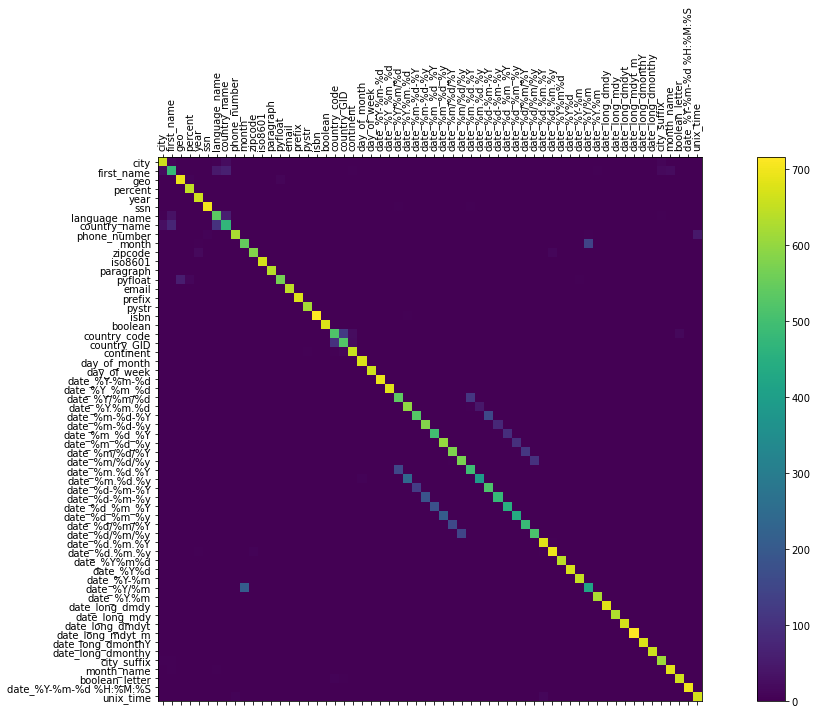

In [75]:
evaluate_test_set(model, test_split, char_vocab, tag_vocab)

In [30]:
# If the model performed well you can save it locally
yourpath = 'models/LSTM_RNN_Geotime_Classify_v_0.07.pth'
torch.save(model, yourpath)

In [76]:
torch.save(model.state_dict(), 'models/LSTM_RNN_Geotime_Classify_v_0.08_dict.pth')